In [ ]:
# Objective: Build an entity-year (EIN-based) panel from FAC audit and federal award data (2019–2022) 
# to predict whether a federal grant recipient will have audit findings in the next audit year (t+1), 
# and explain key drivers of risk using permutation importance and SHAP.

#Tech Stack (Python): Tech stack (Python): pandas, NumPy, scikit-learn, SHAP

#Data Sources: FAC general, awards, and findings data from 2019, 2020, 2021, and 2022

In [1]:
import pandas as pd
import os 
os.getcwd()
os.chdir('/Users/pranavidoodala/iCloud Drive (Archive)/Documents/AGA Datathon')

In [7]:
# Investigative prompts, specifically looking at GSA migration for UEI
DATA_DIR = r"/Users/pranavidoodala/iCloud Drive (Archive)/Documents/AGA Datathon"  # folder where general-ay-YYYY.csv lives
path_2022 = f"{DATA_DIR}/2022-ay-general.csv"

gen22 = pd.read_csv(
    path_2022,
    usecols=["report_id", "auditee_uei", "auditee_ein", "audit_year"],
    dtype={"report_id": "string", "auditee_uei": "string", "auditee_ein": "string", "audit_year": "int64"},
)

# Build crosswalk from EIN -> UEI (using unique pairs)
pairs = gen22[["auditee_ein", "auditee_uei"]].drop_duplicates()

# Check mapping quality
ein_to_uei_counts = pairs.groupby("auditee_ein")["auditee_uei"].nunique().value_counts().sort_index()
uei_to_ein_counts = pairs.groupby("auditee_uei")["auditee_ein"].nunique().value_counts().sort_index()

print("EIN -> #UEIs distribution (how many UEIs per EIN):")
print(ein_to_uei_counts.head(10))
print("\nUEI -> #EINs distribution (how many EINs per UEI):")
print(uei_to_ein_counts.head(10))

# How many EINs map cleanly to exactly one UEI?
clean_eins = (pairs.groupby("auditee_ein")["auditee_uei"].nunique() == 1).mean()
print("\nShare of EINs that map to exactly 1 UEI in 2022:", round(clean_eins, 4))

# Save crosswalk for later use
crosswalk = (pairs.groupby("auditee_ein", as_index=False)
             .agg(auditee_uei=("auditee_uei", "first")))
print("\nCrosswalk rows:", len(crosswalk))
display(crosswalk.head())

EIN -> #UEIs distribution (how many UEIs per EIN):
auditee_uei
1     46921
2       164
3        20
4         7
5         3
6         3
7         3
8         1
10        1
11        1
Name: count, dtype: int64

UEI -> #EINs distribution (how many EINs per UEI):
auditee_ein
1     46922
2       214
3         5
4         2
5         4
9         2
67        1
Name: count, dtype: int64

Share of EINs that map to exactly 1 UEI in 2022: 0.9956

Crosswalk rows: 47127


,auditee_ein,auditee_uei
0,010202467,U46RJM97ML83
1,010211483,G1KZKE3LFK44
2,010211494,D1JMAQKMD9Q7
3,010211497,HTDGDE48GHB5
4,010211513,XR6LMXNKDJJ1


In [4]:
# Creating unified entity key for all years (EIN-based + UEI where possible)
DATA_DIR = r"/Users/pranavidoodala/iCloud Drive (Archive)/Documents/AGA Datathon"  # folder where general-ay-YYYY.csv lives
YEARS = [2019, 2020, 2021, 2022]

def load_general_keys(year):
    df = pd.read_csv(
        f"{DATA_DIR}/{year}-ay-general.csv",
        usecols=["report_id", "auditee_ein", "auditee_uei", "audit_year"],
        dtype={"report_id": "string", "auditee_ein": "string", "auditee_uei": "string", "audit_year": "int64"},
    )
    # Define entity key (EIN)
    df["entity_id"] = df["auditee_ein"]
    return df

general_keys = pd.concat([load_general_keys(y) for y in YEARS], ignore_index=True)

# Build the spine: one row per (entity_id, audit_year)
spine = (general_keys[["entity_id", "audit_year"]]
         .dropna()
         .drop_duplicates()
         .sort_values(["entity_id", "audit_year"])
         .reset_index(drop=True))

print("Spine shape (entity-year rows):", spine.shape)
print("Unique entities:", spine["entity_id"].nunique())
print("Years covered:", spine["audit_year"].unique())

display(spine.head(10))

Spine shape (entity-year rows): (169371, 2)
Unique entities: 56333
Years covered: [2019 2020 2021 2022]


,entity_id,audit_year
0,003460326,2019
1,010202467,2019
2,010202467,2020
3,010202467,2021
4,010202467,2022
5,010211483,2021
6,010211483,2022
7,010211494,2019
8,010211494,2020
9,010211494,2021


In [8]:
# creating general_map once (report_id → entity_id, audit_year)
general_map = (general_keys[["report_id", "entity_id", "audit_year"]]
               .drop_duplicates()
               .reset_index(drop=True))

print("general_map shape:", general_map.shape)
print("report_id unique:", general_map["report_id"].nunique(), " / rows:", len(general_map))
display(general_map.head())

general_map shape: (171551, 3)
report_id unique: 171551  / rows: 171551


,report_id,entity_id,audit_year
0,2019-12-GSAFAC-0000001896,346000236,2019
1,2019-06-GSAFAC-0000007633,660433801,2019
2,2019-10-GSAFAC-0000007833,521558569,2019
3,2019-12-GSAFAC-0000009226,246000719,2019
4,2019-05-GSAFAC-0000008712,382363592,2019


In [9]:
# build findings outcomes per entity-year (t) using report_id → entity_id
DATA_DIR = r"/Users/pranavidoodala/iCloud Drive (Archive)/Documents/AGA Datathon" 

# Reuse: general_map already in memory
# general_map columns: report_id, entity_id, audit_year

def load_findings(year):
    return pd.read_csv(
        f"{DATA_DIR}/{year}-ay-findings.csv",
        usecols=["report_id"],               # keep it minimal for now
        dtype={"report_id": "string"},
    )

# 1) Load findings for all years (report_id only)
findings_ids = pd.concat([load_findings(y) for y in YEARS], ignore_index=True)

# 2) Attach entity_id + audit_year via general_map
findings_joined = findings_ids.merge(general_map, on="report_id", how="left")

# Sanity check: should be nearly all matched
match_rate = findings_joined["entity_id"].notna().mean()
print("Findings rows:", len(findings_joined))
print("Match rate to general_map:", round(match_rate, 4))

# 3) Aggregate to entity-year outcomes at time t
outcomes_t = (findings_joined
    .groupby(["entity_id", "audit_year"], as_index=False)
    .agg(finding_count_t=("report_id", "size"))
)

outcomes_t["has_finding_t"] = (outcomes_t["finding_count_t"] > 0).astype(int)

print("outcomes_t shape:", outcomes_t.shape)
display(outcomes_t.head())

Findings rows: 240600
Match rate to general_map: 1.0
outcomes_t shape: (29620, 4)


,entity_id,audit_year,finding_count_t,has_finding_t
0,010211483,2022,1,1
1,010211494,2021,10,1
2,010211494,2022,7,1
3,010211810,2021,2,1
4,010223482,2021,1,1


In [10]:
# Full outcomes at time t for every (entity_id, audit_year) in spine

outcomes_full_t = spine.merge(outcomes_t, on=["entity_id", "audit_year"], how="left")

outcomes_full_t["finding_count_t"] = outcomes_full_t["finding_count_t"].fillna(0).astype(int)
outcomes_full_t["has_finding_t"] = outcomes_full_t["has_finding_t"].fillna(0).astype(int)

print("outcomes_full_t shape:", outcomes_full_t.shape)
print("has_finding_t rate:", round(outcomes_full_t["has_finding_t"].mean(), 4))

display(outcomes_full_t.head())

outcomes_full_t shape: (169371, 4)
has_finding_t rate: 0.1749


,entity_id,audit_year,finding_count_t,has_finding_t
0,003460326,2019,0,0
1,010202467,2019,0,0
2,010202467,2020,0,0
3,010202467,2021,0,0
4,010202467,2022,0,0


In [11]:
# Create y(t+1) labels by shifting outcomes back one year

next_year = outcomes_full_t[["entity_id", "audit_year", "has_finding_t", "finding_count_t"]].copy()
next_year["audit_year"] = next_year["audit_year"] - 1

next_year = next_year.rename(columns={
    "has_finding_t": "y_has_finding_t1",
    "finding_count_t": "y_finding_count_t1"
})

panel = outcomes_full_t.merge(next_year, on=["entity_id", "audit_year"], how="left")

# Entity-years without an observed t+1 audit will have NaN here
print("panel shape:", panel.shape)
print("Missing y_has_finding_t1 rate:", round(panel["y_has_finding_t1"].isna().mean(), 4))

display(panel.head())

panel shape: (169371, 6)
Missing y_has_finding_t1 rate: 0.3462


,entity_id,audit_year,finding_count_t,has_finding_t,y_has_finding_t1,y_finding_count_t1
0,003460326,2019,0,0,NaN,NaN
1,010202467,2019,0,0,0.0,0.0
2,010202467,2020,0,0,0.0,0.0
3,010202467,2021,0,0,0.0,0.0
4,010202467,2022,0,0,NaN,NaN


In [12]:
# Keep only rows with an observed next-year label

model_base = panel.dropna(subset=["y_has_finding_t1"]).copy()

# Ensure integer types
model_base["y_has_finding_t1"] = model_base["y_has_finding_t1"].astype(int)
model_base["y_finding_count_t1"] = model_base["y_finding_count_t1"].astype(int)

print("model_base shape:", model_base.shape)
print("Years in model_base:", sorted(model_base["audit_year"].unique()))
print("y_has_finding_t1 rate:", round(model_base["y_has_finding_t1"].mean(), 4))

display(model_base.head())

model_base shape: (110739, 6)
Years in model_base: [2019, 2020, 2021]
y_has_finding_t1 rate: 0.1689


,entity_id,audit_year,finding_count_t,has_finding_t,y_has_finding_t1,y_finding_count_t1
1,010202467,2019,0,0,0,0
2,010202467,2020,0,0,0,0
3,010202467,2021,0,0,0,0
5,010211483,2021,0,0,1,1
7,010211494,2019,0,0,0,0


In [13]:
# Build award-based predictors at (entity_id, audit_year) using federal_awards-ay

DATA_DIR = r"/Users/pranavidoodala/iCloud Drive (Archive)/Documents/AGA Datathon"
YEARS = [2019, 2020, 2021]  # predictors only need t years

def load_awards(year):
    df = pd.read_csv(
        f"{DATA_DIR}/{year}-ay-federal_awards.csv",
        dtype={"report_id": "string"},
        low_memory=False
    )
    df["audit_year"] = year
    return df

awards_raw = pd.concat([load_awards(y) for y in YEARS], ignore_index=True)

print("awards_raw shape:", awards_raw.shape)
print("Columns (first 40):", awards_raw.columns.tolist()[:40])

# to identify the amount column and program/agency columns

awards_raw shape: (2096415, 22)
Columns (first 40): ['report_id', 'auditee_uei', 'audit_year', 'award_reference', 'federal_agency_prefix', 'federal_award_extension', 'additional_award_identification', 'federal_program_name', 'amount_expended', 'cluster_name', 'other_cluster_name', 'state_cluster_name', 'cluster_total', 'federal_program_total', 'is_major', 'is_loan', 'loan_balance', 'is_direct', 'audit_report_type', 'findings_count', 'is_passthrough_award', 'passthrough_amount']


In [15]:
# Aggregate federal_awards into predictors at (entity_id, audit_year)

# Attach entity_id + audit_year from general_map
awards = awards_raw.merge(general_map, on="report_id", how="left", suffixes=("", "_gen"))

print("Awards match rate to general_map:", round(awards["entity_id"].notna().mean(), 4))

# Clean numeric fields
for c in ["amount_expended", "cluster_total", "federal_program_total", "loan_balance", "passthrough_amount"]:
    if c in awards.columns:
        awards[c] = pd.to_numeric(awards[c], errors="coerce").fillna(0)

# Aggregate to entity-year predictors
awards_feat = (awards
    .groupby(["entity_id", "audit_year_gen"], as_index=False)
    .agg(
        total_expended=("amount_expended", "sum"),
        award_lines=("amount_expended", "size"),
        distinct_agencies=("federal_agency_prefix", pd.Series.nunique),
        distinct_programs=("federal_program_name", pd.Series.nunique),
        major_award_lines=("is_major", lambda s: (s == "Y").sum() if s.dtype == "object" else s.sum()),
        loan_award_lines=("is_loan", lambda s: (s == "Y").sum() if s.dtype == "object" else s.sum()),
        direct_award_lines=("is_direct", lambda s: (s == "Y").sum() if s.dtype == "object" else s.sum()),
        passthrough_award_lines=("is_passthrough_award", lambda s: (s == "Y").sum() if s.dtype == "object" else s.sum()),
        total_loan_balance=("loan_balance", "sum"),
        total_passthrough_amount=("passthrough_amount", "sum"),
        max_program_total=("federal_program_total", "max"),
    )
    .rename(columns={"audit_year_gen": "audit_year"})
)

print("awards_feat shape:", awards_feat.shape)
display(awards_feat.head())

Awards match rate to general_map: 1.0
awards_feat shape: (122244, 13)


,entity_id,audit_year,total_expended,award_lines,distinct_agencies,distinct_programs,major_award_lines,loan_award_lines,direct_award_lines,passthrough_award_lines,total_loan_balance,total_passthrough_amount,max_program_total
0,003460326,2019,18847955,7,2,7,6,1,7,0,53591.0,0.0,15381372
1,010202467,2019,6782211,17,2,7,17,0,13,3,0.0,2038840.0,6140842
2,010202467,2020,7937968,19,2,8,19,0,15,4,0.0,2162714.0,7212229
3,010202467,2021,8683187,18,2,7,18,0,16,5,0.0,2671215.0,7094851
4,010211483,2021,1687290,12,3,11,2,2,3,0,615872.0,0.0,569731


In [16]:
# Merge predictors into model_base

model_df = model_base.merge(awards_feat, on=["entity_id", "audit_year"], how="left")

# Fill missing predictor values with 0 (means: no awards lines captured)
pred_cols = [
    "total_expended", "award_lines", "distinct_agencies", "distinct_programs",
    "major_award_lines", "loan_award_lines", "direct_award_lines", "passthrough_award_lines",
    "total_loan_balance", "total_passthrough_amount", "max_program_total"
]
for c in pred_cols:
    model_df[c] = model_df[c].fillna(0)

print("model_df shape:", model_df.shape)

# Quick check: any remaining missing predictors?
print("Any NA in predictors?:", model_df[pred_cols].isna().any().any())

display(model_df.head())

model_df shape: (110739, 17)
Any NA in predictors?: False


,entity_id,audit_year,finding_count_t,has_finding_t,y_has_finding_t1,y_finding_count_t1,total_expended,award_lines,distinct_agencies,distinct_programs,major_award_lines,loan_award_lines,direct_award_lines,passthrough_award_lines,total_loan_balance,total_passthrough_amount,max_program_total
0,010202467,2019,0,0,0,0,6782211,17,2,7,17,0,13,3,0.0,2038840.0,6140842
1,010202467,2020,0,0,0,0,7937968,19,2,8,19,0,15,4,0.0,2162714.0,7212229
2,010202467,2021,0,0,0,0,8683187,18,2,7,18,0,16,5,0.0,2671215.0,7094851
3,010211483,2021,0,0,1,1,1687290,12,3,11,2,2,3,0,615872.0,0.0,569731
4,010211494,2019,0,0,0,0,2400752,11,5,11,2,1,6,0,-1.0,0.0,1519766


In [17]:
# PREPROCESSING COMPLETE! finally.

# create a time-based train/test split (train: 2019, 2020; test: 2021)

from sklearn.model_selection import train_test_split

TARGET = "y_has_finding_t1"
FEATURES = [
    "total_expended", "award_lines", "distinct_agencies", "distinct_programs",
    "major_award_lines", "loan_award_lines", "direct_award_lines", "passthrough_award_lines",
    "total_loan_balance", "total_passthrough_amount", "max_program_total",
    "has_finding_t", "finding_count_t"   # include history as predictors
]

train_df = model_df[model_df["audit_year"].isin([2019, 2020])].copy()
test_df  = model_df[model_df["audit_year"].isin([2021])].copy()

X_train = train_df[FEATURES]
y_train = train_df[TARGET].astype(int)

X_test  = test_df[FEATURES]
y_test  = test_df[TARGET].astype(int)

print("Train rows:", len(train_df), " Test rows:", len(test_df))
print("Train positive rate:", round(y_train.mean(), 4), " Test positive rate:", round(y_test.mean(), 4))

Train rows: 70693  Test rows: 40046
Train positive rate: 0.1614  Test positive rate: 0.1821


In [18]:
# train a baseline Logistic Regression + evaluate with PR-AUC

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score

# Baseline model: scaled logistic regression
log_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_model.fit(X_train, y_train)

# Predicted probabilities for the positive class
p_test = log_model.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, p_test)
roc_auc = roc_auc_score(y_test, p_test)

print("LogReg PR-AUC:", round(pr_auc, 4)) #PR_AUC = Precision Recall Area Under the Curve, 
print("LogReg ROC-AUC:", round(roc_auc, 4)) #ROC_AUC = Receiver Operating Characteristic Area Under the Curve

print(f"If you randomly pick one entity-year that will have findings next year and one that won’t, the model will assign a higher risk score to the “will have findings” case about {roc_auc:.00%} of the time.")

# Precision Recall is usually the more meaningful metric when positives are not super common (ours is ~18% in the test year).
# A helpful baseline: if we ranked cases randomly, PR-AUC would be roughly the positive rate (~0.1821). Our model’s 0.5044 is well above baseline, meaning it’s concentrating positives near the top of the ranking.
# Interpreting it practically: across all possible score thresholds, the model maintains much better precision for a given recall than random. It’s a strong sign the model is useful for flagging the riskiest entities type workflows.

LogReg PR-AUC: 0.5044
LogReg ROC-AUC: 0.7575
If you randomly pick one entity-year that will have findings next year and one that won’t, the model will assign a higher risk score to the “will have findings” case about 76% of the time.


In [19]:
# Feature Importance (using Permutation Importance)

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, average_precision_score

# Uses existing objects from prior steps:
# log_model, X_test, y_test, FEATURES

pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

perm = permutation_importance(
    log_model,
    X_test,
    y_test,
    scoring=pr_auc_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": FEATURES,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_df)
print("\nTop 10 features by permutation importance (PR-AUC drop):")
print(imp_df.head(10).to_string(index=False))

,feature,importance_mean,importance_std
11,has_finding_t,0.256431,0.002489
0,total_expended,0.037592,0.002056
12,finding_count_t,0.026058,0.000964
2,distinct_agencies,0.015757,0.002966
1,award_lines,0.008945,0.000725
6,direct_award_lines,0.006893,0.001020
10,max_program_total,0.006294,0.000381
5,loan_award_lines,0.002278,0.000899
9,total_passthrough_amount,0.001579,0.000471
4,major_award_lines,0.000529,0.000098



Top 10 features by permutation importance (PR-AUC drop):
                 feature  importance_mean  importance_std
           has_finding_t         0.256431        0.002489
          total_expended         0.037592        0.002056
         finding_count_t         0.026058        0.000964
       distinct_agencies         0.015757        0.002966
             award_lines         0.008945        0.000725
      direct_award_lines         0.006893        0.001020
       max_program_total         0.006294        0.000381
        loan_award_lines         0.002278        0.000899
total_passthrough_amount         0.001579        0.000471
       major_award_lines         0.000529        0.000098


In [15]:
# How to read importance_mean here: 

    #scoring metric was PR-AUC
    #importance_mean ≈ drop in PR-AUC when that feature is randomly permuted (made useless) while everything else stays the same
    # basically.. the bigger the drop = the more the model relies on it

# 1) has_finding_t (0.2564) — dominant
# If we scramble whether the entity had any findings at time t, PR-AUC drops by about 0.256. <- Huge!
# Means prior findings status is the strongest signal for whether they’ll have findings next year.

# This makes real-world sense: findings are persistent (issues often carry over, remediation takes time, governance/capacity tends to be stable year to year).

# 2) total_expended (0.0376)
# Scrambling total dollars expended drops PR-AUC by 0.038.
# That means scale of federal spending adds meaningful predictive power—bigger spenders may have more complexity, more compliance exposure, more programs, etc.

# 3) finding_count_t (0.0261)
# Beyond the yes/no of findings, the number of findings also matters.
# This suggests severity/volume at t contains extra signal for t+1.

# 4) distinct_agencies (0.0158)
# More agencies involved → more administrative/compliance complexity → higher predictive value.

# 5–7) award_lines, direct_award_lines, max_program_total (0.006–0.009)
# These are all “complexity / concentration” measures:
    # award_lines: how many award/program lines were on SEFA
    # direct_award_lines: direct vs pass-through structure
    # max_program_total: concentration of spend in the largest program
    
# KEY TAKEAWAY: The model’s predictive power is driven primarily by prior audit findings (persistence), 
# followed by spending scale and organizational/compliance complexity (dollars expended, number of agencies, number of award lines, and concentration in the largest program).

In [16]:
from sklearn.metrics import make_scorer, roc_auc_score

# Uses existing objects:
# log_model, X_test, y_test, FEATURES

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

perm_roc = permutation_importance(
    log_model,
    X_test,
    y_test,
    scoring=roc_auc_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp_roc_df = pd.DataFrame({
    "feature": FEATURES,
    "importance_mean": perm_roc.importances_mean,
    "importance_std": perm_roc.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_roc_df)
print("\nTop 10 features by permutation importance (ROC-AUC drop):")
print(imp_roc_df.head(10).to_string(index=False))

,feature,importance_mean,importance_std
11,has_finding_t,0.165198,0.002489
2,distinct_agencies,0.016699,0.001930
0,total_expended,0.015042,0.000842
6,direct_award_lines,0.004496,0.000549
12,finding_count_t,0.003966,0.000570
5,loan_award_lines,0.003455,0.000587
1,award_lines,0.003067,0.000951
3,distinct_programs,0.001781,0.000508
10,max_program_total,0.000910,0.000721
9,total_passthrough_amount,0.000248,0.000170



Top 10 features by permutation importance (ROC-AUC drop):
                 feature  importance_mean  importance_std
           has_finding_t         0.165198        0.002489
       distinct_agencies         0.016699        0.001930
          total_expended         0.015042        0.000842
      direct_award_lines         0.004496        0.000549
         finding_count_t         0.003966        0.000570
        loan_award_lines         0.003455        0.000587
             award_lines         0.003067        0.000951
       distinct_programs         0.001781        0.000508
       max_program_total         0.000910        0.000721
total_passthrough_amount         0.000248        0.000170


In [17]:
# How to interpret: 
# drop in ROC-AUC when the feature is shuffled

# Across both PR-AUC and ROC-AUC, prior findings is by far the most important predictor. 
# Next are measures of funding complexity and scale (distinct agencies, total expended), 
# followed by structural indicators like direct awards and counts of award lines. 
# Some variables (e.g., distinct programs) appear more important under ROC-AUC than PR-AUC, 
# meaning they help overall ranking but contribute less to concentrating true positives at the very top.


In [21]:
# Train a boosted tree model and evaluate PR-AUC + ROC-AUC (if this performs better, use logreg as benchmark)

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

# Uses existing: X_train, y_train, X_test, y_test

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=3,
    max_iter=400,
    random_state=42
)

hgb.fit(X_train, y_train)

p_test = hgb.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, p_test)
roc_auc = roc_auc_score(y_test, p_test)

print("HGB PR-AUC:", round(pr_auc, 4))
print("HGB ROC-AUC:", round(roc_auc, 4))

# No major differences compared to LogReg, could stick to LogReg

# permutation importance for the tree model (PR-AUC)
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

perm_hgb = permutation_importance(
    hgb,
    X_test,
    y_test,
    scoring=pr_auc_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp_hgb_df = pd.DataFrame({
    "feature": FEATURES,
    "importance_mean": perm_hgb.importances_mean,
    "importance_std": perm_hgb.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_hgb_df)
print("\nTop 10 features by permutation importance for HGB (PR-AUC drop):")
print(imp_hgb_df.head(10).to_string(index=False))

HGB PR-AUC: 0.5439
HGB ROC-AUC: 0.7656


,feature,importance_mean,importance_std
11,has_finding_t,0.267921,0.003637
12,finding_count_t,0.071068,0.002898
4,major_award_lines,0.009290,0.000673
6,direct_award_lines,0.007539,0.001351
3,distinct_programs,0.005367,0.000786
1,award_lines,0.002508,0.000828
10,max_program_total,0.001241,0.000507
0,total_expended,0.000664,0.000291
8,total_loan_balance,0.000661,0.000159
7,passthrough_award_lines,0.000496,0.000279



Top 10 features by permutation importance for HGB (PR-AUC drop):
                feature  importance_mean  importance_std
          has_finding_t         0.267921        0.003637
        finding_count_t         0.071068        0.002898
      major_award_lines         0.009290        0.000673
     direct_award_lines         0.007539        0.001351
      distinct_programs         0.005367        0.000786
            award_lines         0.002508        0.000828
      max_program_total         0.001241        0.000507
         total_expended         0.000664        0.000291
     total_loan_balance         0.000661        0.000159
passthrough_award_lines         0.000496        0.000279


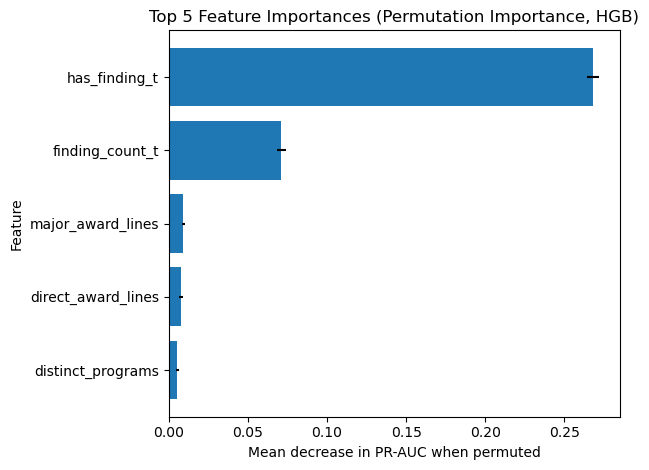

In [23]:
# --- Plot of top 5 permutation importances (horizontal bar) ---
import matplotlib.pyplot as plt

top5 = imp_hgb_df.head(5).sort_values("importance_mean", ascending=True)  # ascending for nice bottom->top order

plt.figure()
plt.barh(
    top5["feature"],
    top5["importance_mean"],
    xerr=top5["importance_std"]
)
plt.xlabel("Mean decrease in PR-AUC when permuted")
plt.ylabel("Feature")
plt.title("Top 5 Feature Importances (Permutation Importance, HGB)")
plt.tight_layout()
plt.show()

In [22]:
# permutation importance for the tree model (ROC-AUC)
# Uses existing: hgb, X_test, y_test, FEATURES
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, roc_auc_score
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

perm_hgb_roc = permutation_importance(
    hgb,
    X_test,
    y_test,
    scoring=roc_auc_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

imp_hgb_roc_df = pd.DataFrame({
    "feature": FEATURES,
    "importance_mean": perm_hgb_roc.importances_mean,
    "importance_std": perm_hgb_roc.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_hgb_roc_df)
print("\nTop 10 features by permutation importance for HGB (ROC-AUC drop):")
print(imp_hgb_roc_df.head(10).to_string(index=False))

,feature,importance_mean,importance_std
11,has_finding_t,0.159015,0.002000
6,direct_award_lines,0.010936,0.001881
12,finding_count_t,0.007775,0.000782
3,distinct_programs,0.002297,0.000888
2,distinct_agencies,0.001978,0.000660
4,major_award_lines,0.001710,0.000386
10,max_program_total,0.001586,0.000821
8,total_loan_balance,0.000385,0.000359
7,passthrough_award_lines,0.000258,0.000220
0,total_expended,0.000174,0.000212



Top 10 features by permutation importance for HGB (ROC-AUC drop):
                feature  importance_mean  importance_std
          has_finding_t         0.159015        0.002000
     direct_award_lines         0.010936        0.001881
        finding_count_t         0.007775        0.000782
      distinct_programs         0.002297        0.000888
      distinct_agencies         0.001978        0.000660
      major_award_lines         0.001710        0.000386
      max_program_total         0.001586        0.000821
     total_loan_balance         0.000385        0.000359
passthrough_award_lines         0.000258        0.000220
         total_expended         0.000174        0.000212


In [20]:
# What ROC-AUC importance says for HGB

# 1) has_finding_t is still the anchor (0.1590)

# Same core takeaway: prior findings status is the biggest driver of ranking performance.

# 2) direct_award_lines jumps to #2 (0.0109)

# This is the biggest change vs PR-AUC (where finding_count_t was #2).

# Interpretation:
    # ROC-AUC rewards features that improve global separation across the full population.
    # Direct award structure seems to help distinguish risk broadly (not just in the “very top” highest-risk slice).

# 3) finding_count_t is still important (0.0078), but less dominant than under PR-AUC

# Under PR-AUC, finding_count_t was huge because it likely helps concentrate true positives at the top.
# Under ROC-AUC, it still helps ranking, but the benefit is more modest relative to direct-award structure.

# 4) Complexity features form the “next tier”
    # distinct_programs, distinct_agencies, major_award_lines, max_program_total
    # These collectively say: diversity + structure + concentration matters.

# 5) total_expended remains near zero

# Same conclusion as before: once the model has complexity/structure measures, raw dollars add little additional ranking power.

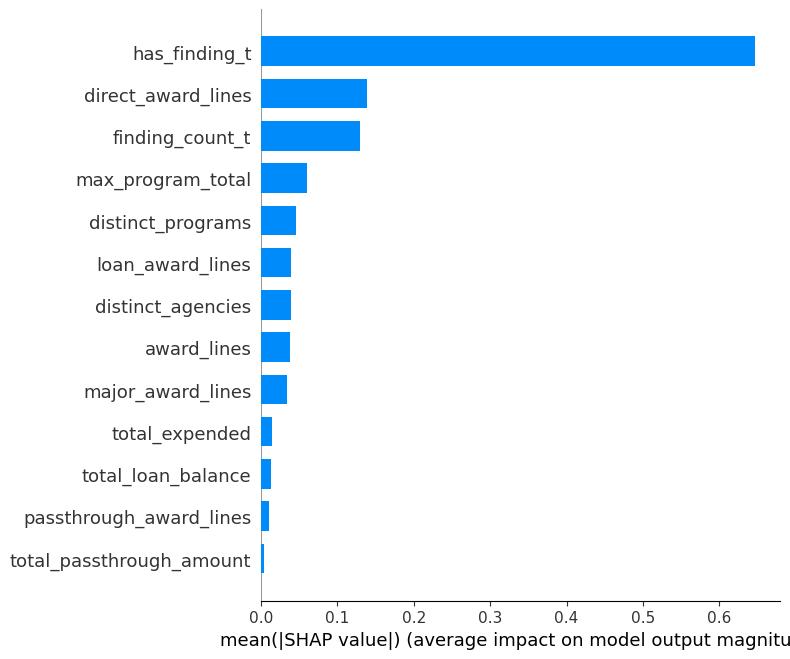

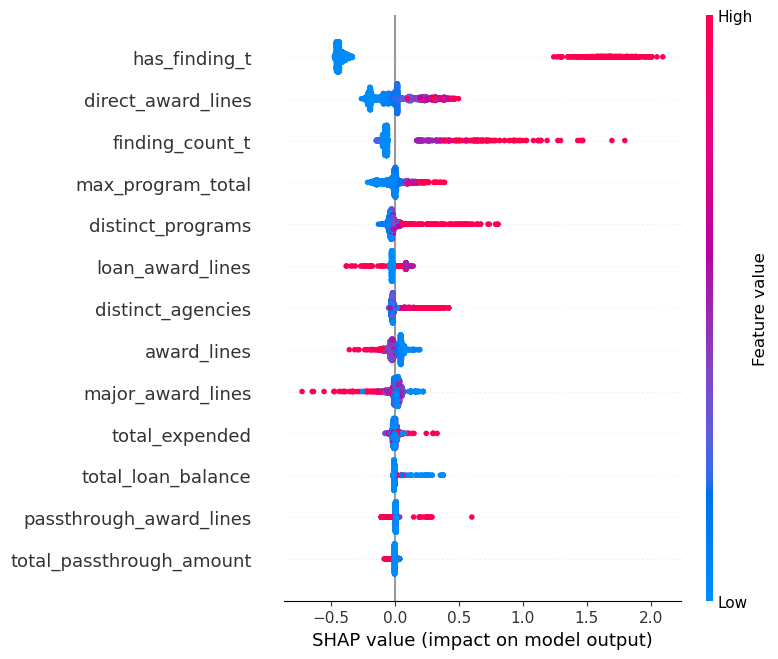

In [21]:
# SHAP for HGB model

import numpy as np
import shap

# Uses existing: hgb, X_train, X_test, FEATURES

# 1) Take small background + evaluation samples (keeps SHAP fast)
X_bg = X_train.sample(n=min(500, len(X_train)), random_state=42)
X_eval = X_test.sample(n=min(2000, len(X_test)), random_state=42)

# 2) Build explainer (SHAP will pick a method; if it falls back to permutation, it's still valid)
explainer = shap.Explainer(hgb, X_bg)

# 3) Compute SHAP values
sv = explainer(X_eval)

# 4) For binary classifiers, SHAP output can be (n, p) or (n, p, 2). We want class=1.
values = sv.values
base = sv.base_values

if values.ndim == 3:
    # class axis is last; take positive class
    sv_pos_values = values[:, :, 1]
    base_pos = base[:, 1] if np.ndim(base) > 1 else base
else:
    sv_pos_values = values
    base_pos = base

# 5) Global importance bar plot (mean absolute SHAP)
shap.summary_plot(sv_pos_values, X_eval, plot_type="bar", feature_names=FEATURES)

# 6) Beeswarm plot (direction + distribution)
shap.summary_plot(sv_pos_values, X_eval, feature_names=FEATURES)

In [ ]:
# The model primarily learns persistence of audit issues: having findings in year t strongly increases 
# the predicted probability of findings in t+1, and a higher number of findings further raises risk. 
# Secondary drivers are award structure and complexity—more direct award lines, greater program/agency diversity, 
# and larger program totals tend to push risk upward.

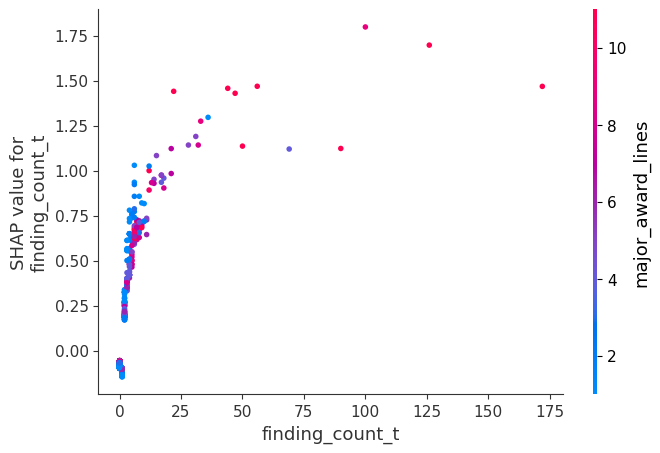

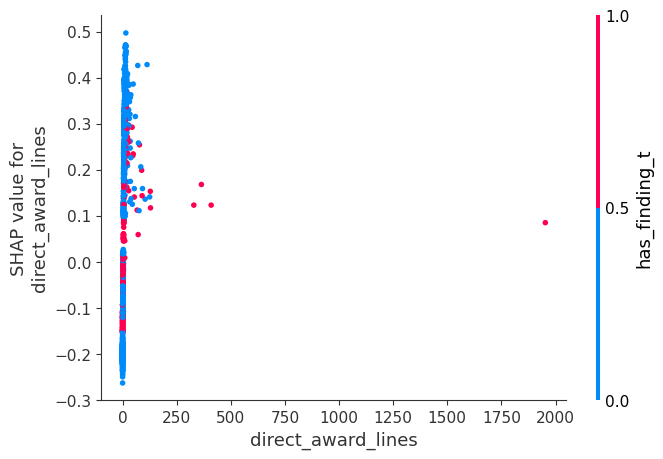

In [28]:
# Uses existing: sv_pos_values, X_eval, FEATURES
# (These were created in your SHAP step)

# 1) Dependence: finding_count_t
shap.dependence_plot(
    "finding_count_t",
    sv_pos_values,
    X_eval,
    feature_names=FEATURES,
)

# 2) Dependence: direct_award_lines
shap.dependence_plot(
    "direct_award_lines",
    sv_pos_values,
    X_eval,
    feature_names=FEATURES,
)

In [29]:
# Graph 1: The model shows a strong non-linear relationship: going from 0 to a small number of findings dramatically 
# increases predicted next-year risk, with diminishing additional impact at higher finding counts. 
# This effect is stronger for entities with more major award lines.

# Graph 2: The effect of direct award complexity is interaction-driven: additional direct award lines generally 
# increase risk, and the increase is more pronounced when the entity had findings in the current year.